In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-06-23 10:26:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.81.208, 172.217.13.240, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.81.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-06-23 10:26:38 (108 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



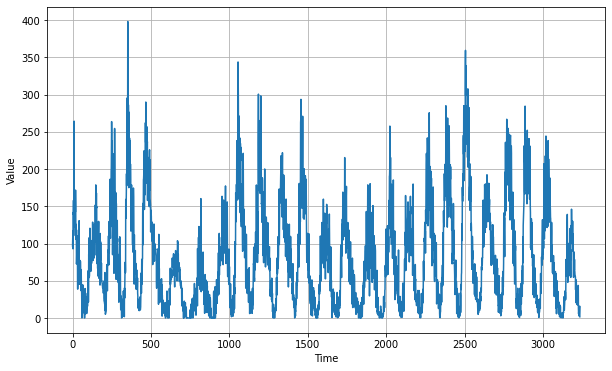

In [6]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

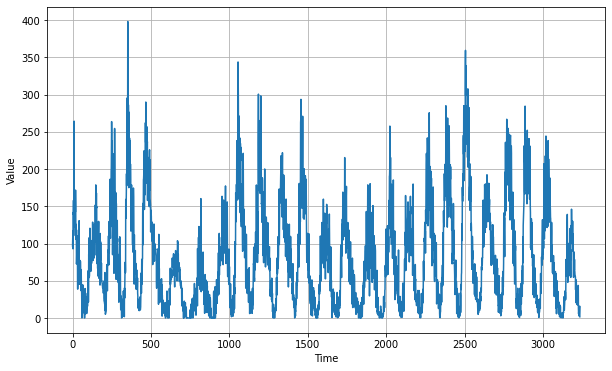

In [7]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 35s 28ms/step - loss: 79.8340 - mae: 80.3314
Epoch 2/100
12/12 [==============================] - 0s 30ms/step - loss: 78.0944 - mae: 78.5918
Epoch 3/100
12/12 [==============================] - 0s 28ms/step - loss: 75.4519 - mae: 75.9497
Epoch 4/100
12/12 [==============================] - 0s 30ms/step - loss: 72.2679 - mae: 72.7658
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 68.7693 - mae: 69.2672
Epoch 6/100
12/12 [==============================] - 0s 28ms/step - loss: 65.1128 - mae: 65.6099
Epoch 7/100
12/12 [==============================] - 0s 29ms/step - loss: 61.5272 - mae: 62.0241
Epoch 8/100
12/12 [==============================] - 0s 27ms/step - loss: 58.1406 - mae: 58.6369
Epoch 9/100
12/12 [==============================] - 0s 29ms/step - loss: 55.0732 - mae: 55.5697
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

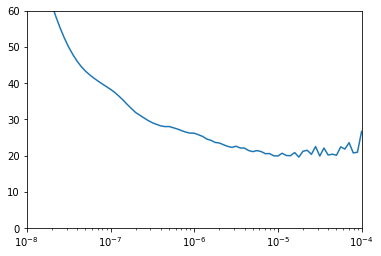

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 31ms/step - loss: 38.9172 - mae: 39.4135
Epoch 2/500
30/30 [==============================] - 1s 17ms/step - loss: 25.7615 - mae: 26.2560
Epoch 3/500
30/30 [==============================] - 1s 16ms/step - loss: 22.0736 - mae: 22.5673
Epoch 4/500
30/30 [==============================] - 1s 15ms/step - loss: 20.4488 - mae: 20.9416
Epoch 5/500
30/30 [==============================] - 1s 16ms/step - loss: 19.7588 - mae: 20.2512
Epoch 6/500
30/30 [==============================] - 1s 16ms/step - loss: 19.3584 - mae: 19.8506
Epoch 7/500
30/30 [==============================] - 1s 16ms/step - loss: 18.5332 - mae: 19.0251
Epoch 8/500
30/30 [==============================] - 1s 18ms/step - loss: 18.3216 - mae: 18.8130
Epoch 9/500
30/30 [==============================] - 1s 17ms/step - loss: 17.9939 - mae: 18.4854
Epoch 10/500
30/30 [==============================] - 1s 16ms/step - loss: 18.0531 - mae: 18.5443
Epoch 11/500
30/30 [=========

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

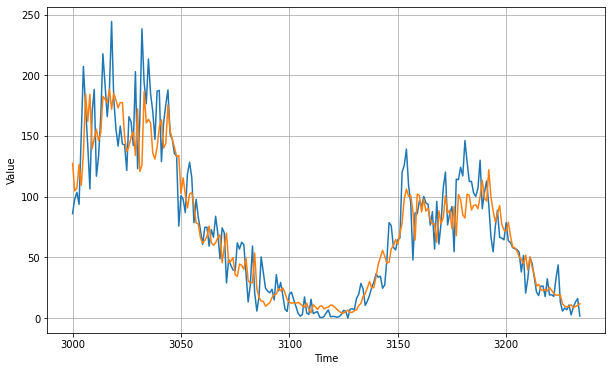

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.660962

<Figure size 432x288 with 0 Axes>

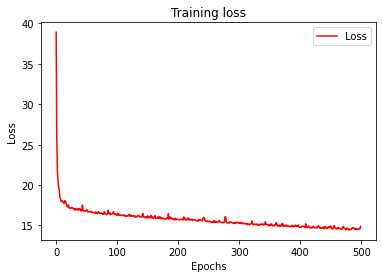

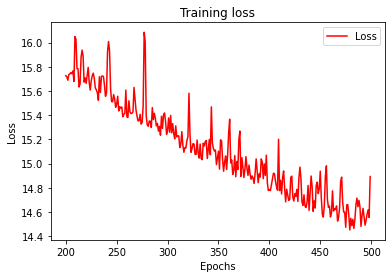

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [19]:
print(rnn_forecast)

[127.41248   104.73304   106.99749   126.341675  109.25144   135.34625
 184.56421   161.93224   184.21765   139.26823   147.97523   155.52365
 146.0846    152.44519   182.59955   180.20293   177.31947   188.54204
 171.96371   185.11554   179.58841   173.23029   177.53899   177.35693
 149.1841    137.02885   141.28137   148.97491   153.28606   133.78253
 172.29295   120.69486   125.6154    186.61436   160.6498    163.7339
 160.56148   135.90723   130.90381   140.6864    157.04141   163.27115
 139.96729   143.68289   175.51094   154.11984   147.39145   140.6132
 132.94899   133.89427   102.692726  115.461205  102.10866    90.64429
 102.37509   103.21016    93.20288    78.291534   77.46813    65.95234
  61.672676   63.91891    67.260704   75.73811    62.119972   59.82697
  62.075424   66.09858    68.57662    45.594364   59.00308    69.86385
  45.561184   46.82742    49.73306    35.640335   34.218822   44.392853
  43.398964   40.05664    49.449738   30.750948   28.87243    28.988838
  53.5